### split the data

In [1]:
# Follow the data split rate, randomly seperate images into 2 groups --train and validation, with correspinding 
# annotations, then save the images and annotation json file sets in the different directory (train & validation)

from glob import glob
import json
import shutil
from random import random, shuffle

def splitDataset(imgpath_input, annotpath_input, path_output_val, path_output_train, split_rate):
    image_paths = glob(imgpath_input)
    shuffle(image_paths)
    # image_paths = imgpath
    # print(image_paths)
    # Path to your annotations from VIA tool
    annotation_file = annotpath_input
    # clean up the annotations a little
    annotations = json.load(open(annotation_file))
    # print(annotations)
    cleaned_annotations = {}
    for k, v in annotations['_via_img_metadata'].items():
        cleaned_annotations[v['filename']] = v

    train_annotations = {}
    valid_annotations = {}
    validation_size = round(len(image_paths)*split_rate)
    # size of images in validation folder
    for img in image_paths[:validation_size]:
        # Image goes to Validation folder
        shutil.copy2(img, path_output_val)
        img = img.split("/")[-1]
        valid_annotations[img] = cleaned_annotations[img]
    for img in image_paths[validation_size:]:
        shutil.copy2(img, path_output_train)
        img = img.split("/")[-1]
        train_annotations[img] = cleaned_annotations[img]
    # put different annotations in different folders
    with open(path_output_val + 'via_region_data.json', 'w') as fp:
        json.dump(valid_annotations, fp)
    with open(path_output_train + 'via_region_data.json', 'w') as fp:
        json.dump(train_annotations, fp)
    print("+++++ finish split dataset +++++")

In [2]:
#Split the data
path_input = "/home/ada/Mask_RCNN/Colonocopy_Doc/datastore/colon_datastore/*"
annot_input = "/home/ada/Mask_RCNN/Colonocopy_Doc/datastore/anottation_dataset/new_hollow.json"
path_output_val = "/home/ada/Mask_RCNN/Colonocopy_Doc/dataset_for_train/val/"
path_output_train = "/home/ada/Mask_RCNN/Colonocopy_Doc/dataset_for_train/train/"
# 20% Image goes to Validation folder
splitDataset(path_input, annot_input, path_output_val, path_output_train, 0.2)

+++++ finish split dataset +++++


### Create train and Validation Dataset

In [1]:
import os
ROOT_DIR = os.path.abspath("../../")
import sys
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import numpy as np
import skimage.draw
import os
import json


class PolypDataset(utils.Dataset):

    def load_polyp(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("polyp", 1, "polyp")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "polyp",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a polyp dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "polyp":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "polyp":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [2]:
dataset_dir = "/home/ada/Documents/Dataset/build_612_04012020/"
# generate the train set
train_set = PolypDataset()
train_set.load_polyp(dataset_dir, "train")

# Must call before using the dataset
train_set.prepare()

print("Train Image Count: {}".format(len(train_set.image_ids)))
print("Class Count: {}".format(train_set.num_classes))
for i, info in enumerate(train_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Train Image Count: 494
Class Count: 2
  0. BG                                                
  1. polyp                                             


In [3]:
!which python

/home/ada/miniconda3/envs/mrcnn/bin/python


In [4]:
# generate the validation set
val_set = PolypDataset()
val_set.load_polyp(dataset_dir, 'val')
val_set.prepare()

print("Validation Image Count: {}".format(len(val_set.image_ids)))
print("Class Count: {}".format(val_set.num_classes))
for i, info in enumerate(val_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Validation Image Count: 118
Class Count: 2
  0. BG                                                
  1. polyp                                             


### visualization

image shape:  (266, 314, 3)
mask shape:  (266, 314, 1)
class id:  [1]
<class 'numpy.ndarray'>


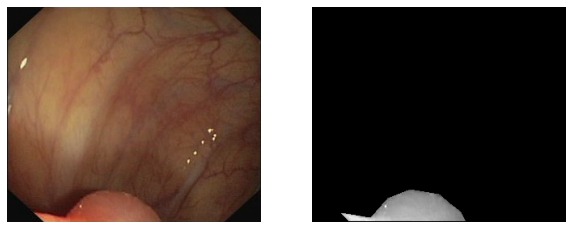

In [5]:
# Load and display random sample and their bounding boxes

import matplotlib.pyplot as plt
import random
import numpy as np

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(val_set.image_ids)
    image_fp = val_set.image_reference(image_id)
    image = val_set.load_image(image_id)
    mask, class_ids = val_set.load_mask(image_id)

print('image shape: ', image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print('mask shape: ', mask.shape)
print('class id: ', class_ids)
print(type(masked))

del masked

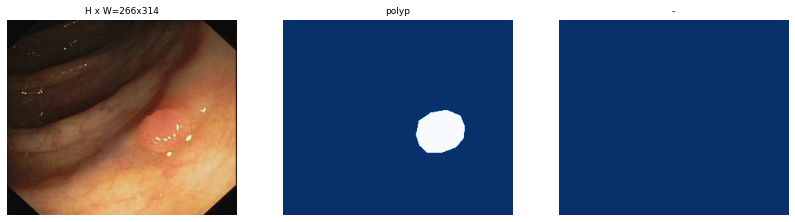

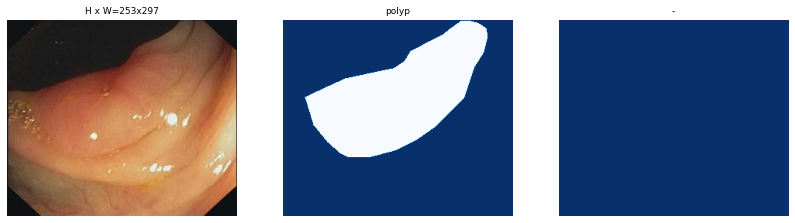

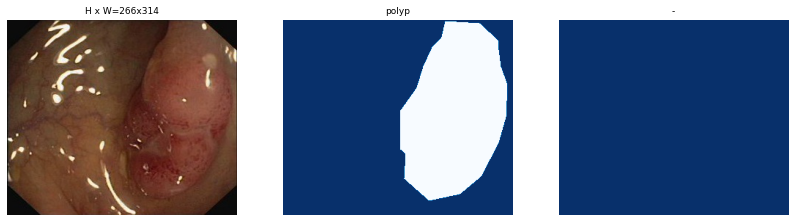

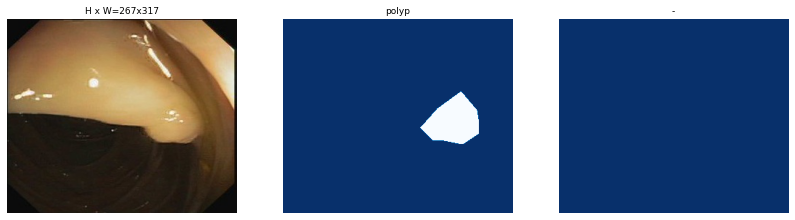

In [12]:
image_ids = np.random.choice(train_set.image_ids, 4)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names,limit=2)

    class_ids = np.array([int(x) for x in class_ids])
    # Compute Bounding box
    bbox = utils.extract_bboxes(mask)

In [6]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.polyp import polyp

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = "/home/ada/Documents/Mask_RCNN/mrcnn/mask_rcnn_balloon.h5"  # TODO: update this path

## Configurations

In [7]:
config = polyp.PolypConfig()
POLYP_DIR = '/home/ada/Documents/Dataset/build_612_04012020/'

In [8]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [9]:
DEVICE = "/gpu:0"

In [10]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR,
                              config=config)

In [11]:
weights_path = '../../mrcnn/mask_rcnn_balloon.h5'
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  ../../mrcnn/mask_rcnn_balloon.h5


### Training the header layer

In [13]:
%%time
start = time.time()
model.train(train_set, val_set,
                learning_rate=1e-4,
                epochs=30,
                layers='heads')
history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/ada/Documents/Mask_RCNN/logs/polyp20211224T1652/mask_rcnn_polyp_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_dec

/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

Epoch 1/30


/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ada/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

NotFoundError: 2 root error(s) found.
  (0) Not found: No algorithm worked!
	 [[{{node conv1/Conv2D}}]]
	 [[proposal_targets/strided_slice_16/_4611]]
  (1) Not found: No algorithm worked!
	 [[{{node conv1/Conv2D}}]]
0 successful operations.
0 derived errors ignored.